## Code examples

We start by importing the necessary packages

In [1]:
import numpy
import matplotlib.pyplot as plt
from equilibrator_api import ComponentContribution, Q_

### Basic *ΔG'* calculations

Create an instance of `ComponentContribution`, which is the main interface for using eQuilibrator. This command loads all the data that is required to calculate thermodynamic potentials of reactions, and it is normal for it to take 10-20 seconds to execute.
If you are running it for the first time on a new computer, it will download a 1.3 GB file, which might take a few minutes or up to an hour (depending on your bandwidth). Don't worry, it will only happen once.

In [2]:
cc = ComponentContribution()
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

You can parse a reaction formula that uses compound accessions from different databases (KEGG, ChEBI, MetaNetX, BiGG, and a few others). The following example is ATP hydrolysis to ADP and inorganic phosphate, using BiGG metabolite IDs:

In [3]:
atpase_reaction = cc.parse_reaction_formula(
    "bigg.metabolite:atp + bigg.metabolite:h2o = "
    "bigg.metabolite:adp + bigg.metabolite:pi"
)

We highly recommend that you check that the reaction is atomically balanced (conserves atoms) and charge balanced (redox neutral). We’ve found that it’s easy to accidentally write unbalanced reactions in this format (e.g. forgetting to balance water is a common mistake) and so we always check ourselves.

In [4]:
print("The reaction is " + ("" if atpase_reaction.is_balanced() else "not ") + "balanced")    

The reaction is balanced


Now we know that the reaction is "kosher" and we can safely proceed to calculate the standard change in Gibbs potential due to this reaction.

In [5]:
dG0_prime = cc.standard_dg_prime(atpase_reaction)
print(f"ΔG'° = {dG0_prime}")

dGm_prime = cc.physiological_dg_prime(atpase_reaction)
print(f"ΔG'm = {dGm_prime}")

atpase_reaction.set_abundance(cc.get_compound("bigg.metabolite:atp"), Q_("1 mM"))
atpase_reaction.set_abundance(cc.get_compound("bigg.metabolite:adp"), Q_("100 uM"))
atpase_reaction.set_abundance(cc.get_compound("bigg.metabolite:pi"), Q_("0.003 M"))

dG_prime = cc.dg_prime(atpase_reaction)
print(f"ΔG' = {dG_prime}")

ΔG'° = (-29.14 +/- 0.30) kilojoule / mole
ΔG'm = (-46.26 +/- 0.30) kilojoule / mole
ΔG' = (-49.24 +/- 0.30) kilojoule / mole


The return values are `pint.Measurement` objects. If you want to extract the Gibbs energy value and error as floats, you can use the following commands:

In [6]:
dG_prime_value_in_kj_per_mol = dG_prime.value.m_as("kJ/mol")
dG_prime_error_in_kj_per_mol = dG_prime.error.m_as("kJ/mol")
print(
    f"ΔG'° = {dG_prime_value_in_kj_per_mol:.1f} +/- "
    f"{dG_prime_error_in_kj_per_mol:.1f} kJ/mol"
)

ΔG'° = -49.2 +/- 0.3 kJ/mol


### The reversibility index

You can also calculate the reversibility index for this reaction.

In [7]:
print(f"ln(Reversibility Index) = {cc.ln_reversibility_index(atpase_reaction)}")

ln(Reversibility Index) = (-12.45 +/- 0.08) dimensionless


The reversibility index is a measure of the degree of the reversibility of the reaction that is normalized for stoichiometry. If you are interested in assigning reversibility to reactions we recommend this measure because 1:2 reactions are much “easier” to reverse than reactions with 1:1 or 2:2 reactions. You can see [our paper](https://pubmed.ncbi.nlm.nih.gov/22645166/) for more information.

### Further examples for reaction parsing



Parsing reaction with non-trivial stoichiometric coefficients is simple. Just add the coefficients before each compound ID (if none is given, it is assumed to be 1)

In [8]:
rubisco_reaction = cc.parse_reaction_formula(
    "kegg:C01182 + kegg:C00011 + kegg:C00001 = 2 kegg:C00197"
)
dG0_prime = cc.standard_dg_prime(rubisco_reaction)
print(f"ΔG'° = {dG0_prime}")

ΔG'° = (-31 +/- 4) kilojoule / mole


We support several compound databases, not just BiGG. One can mix between several sources in the same reaction, e.g.:

In [9]:
atpase_reaction = cc.parse_reaction_formula(
    "kegg:C00002 + CHEBI:15377 = metanetx.chemical:MNXM7 + bigg.metabolite:pi"
)
dG0_prime = cc.standard_dg_prime(atpase_reaction)
print(f"ΔG'° = {dG0_prime}")

ΔG'° = (-29.14 +/- 0.30) kilojoule / mole


Or, you can use compound names instead of identifiers. However, it is discouraged to use in batch, since we only pick the closest hit in our database, and that can often be the wrong compound. Always verify that the reaction is balanced, and preferably also that the InChIKeys are correct:

In [10]:
glucose_isomerase_reaction = cc.search_reaction("beta-D-glucose = glucose")
for cpd, coeff in glucose_isomerase_reaction.items():
    print(f"{coeff:5.0f}  {cpd.get_common_name():15s} {cpd.inchi_key}")
dG0_prime = cc.standard_dg_prime(glucose_isomerase_reaction)
print(f"ΔG'° = {dG0_prime}")

   -1  BETA-D-GLUCOSE  WQZGKKKJIJFFOK-VFUOTHLCSA-N
    1  D-Glucose       WQZGKKKJIJFFOK-GASJEMHNSA-N
ΔG'° = (-1.6 +/- 1.3) kilojoule / mole


In this case, the matcher arbitrarily chooses $\alpha$-D-glucose as the first hit for the name `glucose`. Therefore, it is always better to use the most specific synonym to avoid mis-annotations.

### *ΔG'°* of ATP hydrolysis as a function of pH and pMg

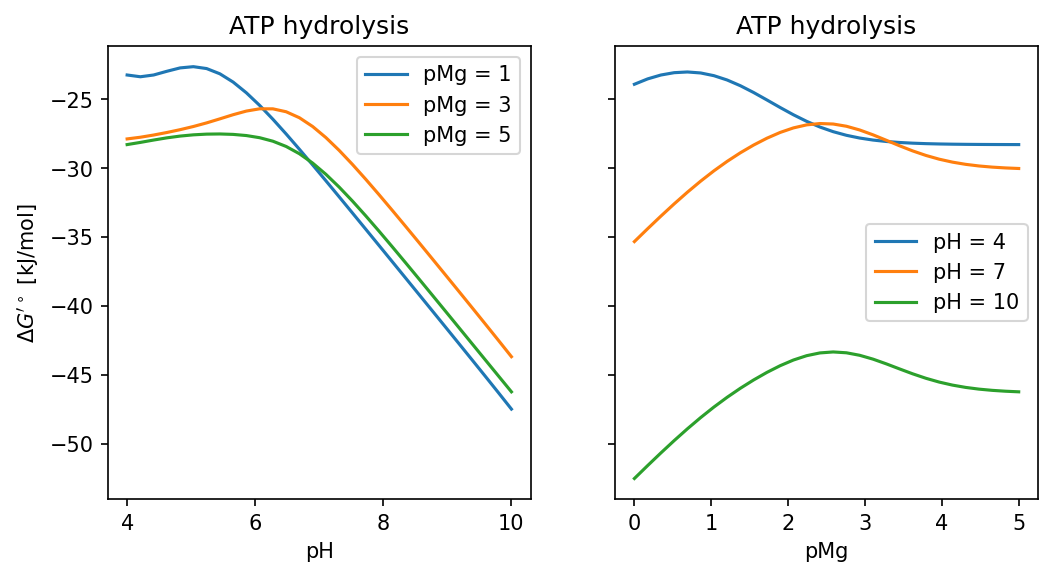

In [11]:
def calc_dg(p_h, p_mg):
    cc.p_h = Q_(p_h)
    cc.p_mg = Q_(p_mg)
    return cc.standard_dg_prime(atpase_reaction).value.m_as("kJ/mol")

fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True)

ax = axs[0]
ph_range = numpy.linspace(4, 10, 30)
ax.plot(ph_range, [calc_dg(p_h, 1) for p_h in ph_range], '-', label="pMg = 1")
ax.plot(ph_range, [calc_dg(p_h, 3) for p_h in ph_range], '-', label="pMg = 3")
ax.plot(ph_range, [calc_dg(p_h, 5) for p_h in ph_range], '-', label="pMg = 5")
ax.set_xlabel('pH')
ax.set_ylabel(r"$\Delta G'^\circ$ [kJ/mol]")
ax.set_title("ATP hydrolysis")
ax.legend();

ax = axs[1]
pmg_range = numpy.linspace(0, 5, 30)
ax.plot(pmg_range, [calc_dg(4, p_mg) for p_mg in pmg_range], '-', label="pH = 4")
ax.plot(pmg_range, [calc_dg(7, p_mg) for p_mg in pmg_range], '-', label="pH = 7")
ax.plot(pmg_range, [calc_dg(10, p_mg) for p_mg in pmg_range], '-', label="pH = 10")
ax.set_xlabel('pMg')
ax.set_title("ATP hydrolysis")
ax.legend();

# don't forget to change the aqueous conditions back to the default ones
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")